<a href="https://colab.research.google.com/github/offthetab/NN_homework/blob/main/%D0%9F%D0%A0_2_%D0%9E%D0%BF%D1%82%D0%B8%D0%BC%D0%B8%D0%B7%D0%B0%D1%82%D0%BE%D1%80%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Методы оптимизации
*   SGD
*   SGD с импульсом
*   AdaGrad
*   AdaDelta
*   RMSProp
*   Adam
*   AdaMax
*   Nadam

### Задание
Сравнить качество полносвязной сети для решения задачи
классификации на примере данных FashionMNIST, используя
разные оптимизаторы (к рассмотренным оптимизаторам
добавить еще 2 других, описать их работу).

In [ ]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import torchvision.datasets


In [ ]:
# загружаем данные
train = torchvision.datasets.FashionMNIST('./', download = True, train = True)
test = torchvision.datasets.FashionMNIST('./', download = True, train = False)

100%|██████████| 26421880/26421880 [00:02<00:00, 13011425.77it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 229446.51it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 4253838.08it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6170985.14it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
# разделяем на обучающие и тестовое множество
X_train = train.train_data
y_train = train.train_labels
X_test = test.test_data
y_test = test.test_labels

X_train.dtype

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.uint8

In [ ]:
#данные имеют тип беззнаковый 8, а таргеты - целые 64 бита
#преобразуем данные в веществиенный тип
X_train = X_train.float()
X_test = X_test.float()

print(X_train.dtype)
print(y_train.dtype)
print(X_test.dtype)
print(y_test.dtype)

torch.float32
torch.int64
torch.float32
torch.int64


In [ ]:
# Размерность датасетов
print(X_train.shape, X_test.shape)

# кол-во классов
print(y_train.unique())

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [ ]:
# сейчас у нас данные в виде трехмерного тензора (60000 картинок с размерностью 28 на 28 пикселей)
# каждую картинку превратим в вектор длинной 28 * 28 = 784 пикселей

X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

print(X_train)
print(type(X_train))
print(y_test.dtype)

NameError: name 'X_train' is not defined

In [ ]:
class MNISTnet(th.nn.Module):
  def __init__(self):
      super(MNISTnet, self).__init__()

      # 1 входной слой
      self.fc1 = th.nn.Linear(28 * 28, 20)
      self.act1 = th.nn.Sigmoid()

      # 2 скрытый слой
      self.fc2 = th.nn.Linear(20, 20)
      self.act2 = th.nn.LeakyReLU()

      # 3 выходной слой
      self.out = th.nn.Linear(20, 10) # числа от 0 до 9
      self.sm = th.nn.Softmax(dim=1) # вероятность принадлежности к калассу

  def forward(self, x):
      x = self.fc1(x)
      x = self.act1(x)

      x = self.fc2(x)
      x = self.act2(x)

      x = self.out(x)
      return x

  def predict(self, x):
      with th.no_grad():
        x = self.forward(x)
        x = x.reshape(1, -1)
        x = self.sm(x)
        return x


In [ ]:
# функция потерь
loss = th.nn.CrossEntropyLoss() # Кросс-энтропия

loss_dict = {} # тут будем хранить ошибки каждого метода отпимизации

In [ ]:
def start(net, optimizator, loss=loss, batch_size=200, epochs=100):
  train_loss = []
  test_loss = []

  for epoch in range(epochs):
    order = np.random.permutation(len(X_train))
    for start_index in range (0,len(X_train), batch_size):

      opt.zero_grad() # обнуляем градиент оптимизатора

      batch_indexes = order[start_index:start_index + batch_size]
      X_batch = X_train[batch_indexes]
      y_batch = y_train[batch_indexes]

      preds = net.forward(X_batch)
      loss_value = loss(preds, y_batch)
      loss_value.backward()

      opt.step()  # обновление параметров

    with th.no_grad(): # Без вычисления градиентов
      # train loss
      train_prediction = net.forward(X_train)
      train_loss.append(float(loss(train_prediction, y_train)))

      # test loss
      test_prediction = net.forward(X_test)
      test_loss.append(float(loss(test_prediction, y_test)))

  return train_loss, test_loss

In [ ]:
# SGD momentum учитывает предыдущие значения градиента
net = MNISTnet()
opt = th.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

loss_dict["SGD_momentum"] = start(net, opt)

In [ ]:
# AdaGrad
# AdaGrad для разных параметров w устанавливает разные скорости обучения.Чем больше сумма квадратов градиента у параметра,
# тем меньше будет его скорость обучения (lr). Полезно чтобы не проскочить минимум.
# прблема - затухание градиена

net = MNISTnet()
opt = th.optim.Adagrad(net.parameters(), lr=0.001)

loss_dict["AdaGrad"] = start(net, opt)

In [ ]:
# AdaDelta использует метод скользящего среднего, чтобы ограничить возрастание суммы градиентов и, как следствие, предотвратить сильное уменьшение скорости обучения.
net = MNISTnet()
opt = th.optim.Adadelta(net.parameters(), lr=0.001, rho=0.9)

loss_dict["AdaDelta"] = start(net, opt)

In [ ]:
# RMSProp
# Здесь мы не просто складываем квадраты градиентов, а усредняем их с помощью экспоненциальной скользящей средней (EMA)
#

net = MNISTnet()
opt = th.optim.RMSprop(net.parameters(), lr=0.001, alpha=0.99, weight_decay=0.1) # alpha = коэффициент сглаживаия, weight_decay - L2 penalty

loss_dict["RMSProp"] = start(net, opt)

In [ ]:
# Adam
# Он сочетает в себе идею накопления импульса и идею более слабого обновления весов.
# Адам можно рассматривать как комбинацию RMSprop и SGD с импульсом
#
net = MNISTnet()
opt = th.optim.Adam(net.parameters(), lr=0.001)

loss_dict["Adam"] = start(net, opt)

In [ ]:
# AdaMax (написать как работает) Если Адам считает это значение по квадрату градиентов, то Adamax использует максимальное значение градиента
net = MNISTnet()
opt = th.optim.Adamax(net.parameters(), lr=0.001, betas=(0.95, 0.99))

loss_dict["AdaMax"] = start(net, opt)

In [ ]:
# Nadam (написать как работает)
net = MNISTnet()
opt = th.optim.NAdam(net.parameters(), lr=0.001, betas=(0.95, 0.99))

loss_dict["Nadam"] = start(net, opt)

In [ ]:
loss_dict.keys()

dict_keys(['SGD_momentum', 'AdaGrad', 'AdaDelta', 'RMSProp', 'Adam', 'AdaMax', 'Nadam'])

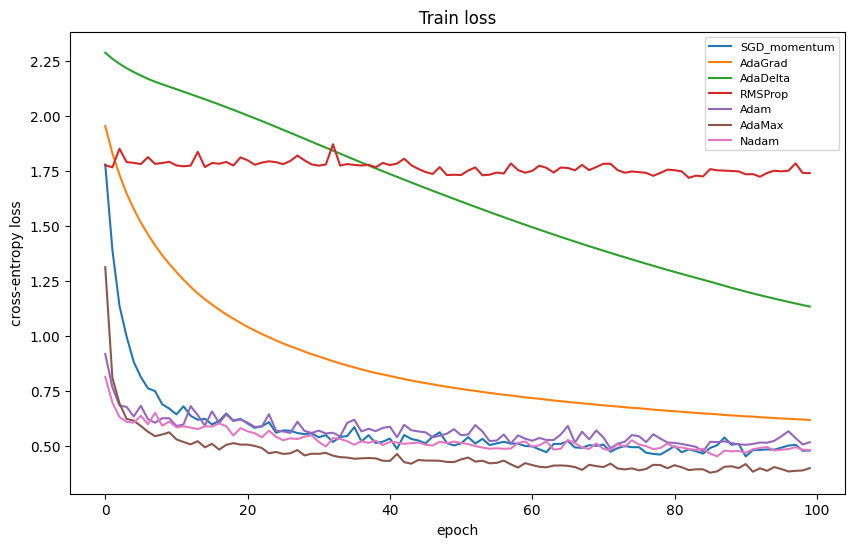

In [ ]:
plt.figure(figsize=(10,6))
for optim in loss_dict.keys():
  plt.plot(loss_dict[optim][0], label=optim)
plt.xlabel("epoch")
plt.ylabel("cross-entropy loss")
plt.title("Train loss")
plt.legend(loc=1, prop={'size': 8})
plt.show()

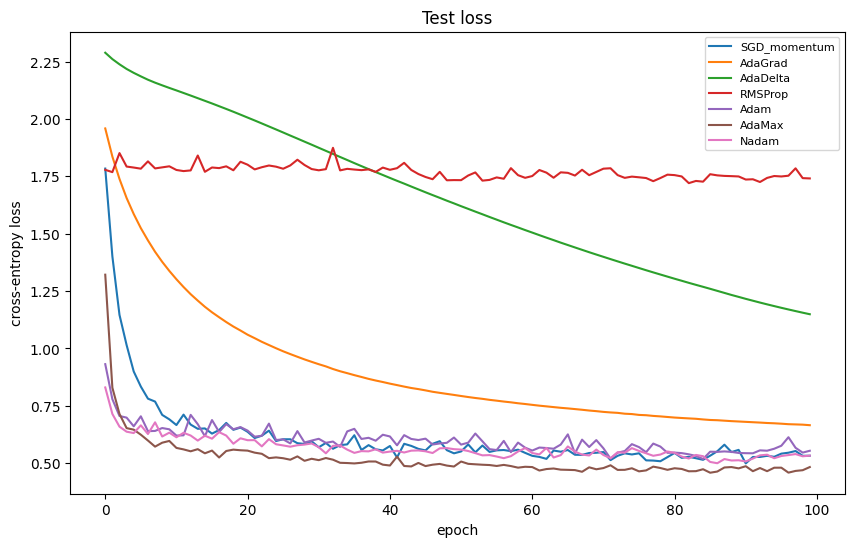

In [ ]:
plt.figure(figsize=(10,6))
for optim in loss_dict.keys():
  plt.plot(loss_dict[optim][1], label=optim)
plt.xlabel("epoch")
plt.ylabel("cross-entropy loss")
plt.title("Test loss")
plt.legend(loc=1, prop={'size': 8})
plt.show()